In [5]:
import os
import torchaudio
import IPython
import requests
import torch
import torchaudio
import numpy as np

def wav2vec_2(wav,sr):
    torch.random.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bundle = torchaudio.pipelines.WAV2VEC2_BASE
    model = bundle.get_model().to(device)
    bundle = torchaudio.pipelines.WAV2VEC2_BASE
    waveform, sample_rate =wav ,sr
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    with torch.inference_mode():
        features, _ = model(waveform)

        
    #stddev_features = np.std(features.cpu().numpy(), axis=0)
    return features

In [6]:
import dill
# data_path=  'D:/DAMP/Research/dilldata/CRNN_train_1.dill'
# data = dill.load(open(data_path, 'rb')) #list

# for item in data:
#     wav = item['audio'][0]
#     sr = item['audio'][1]
#     wav = torch.tensor(wav)
#     wav = wav[None, :].to(torch.float32)
#     wav2vec =  wav2vec_2(wav,sr)
#     items = wav2vec.cpu().data.numpy()
#     items = np.squeeze(items, axis=0)
#     items = np.std(items, axis=0)
#     items = items.tolist()
#     item['w2v_2'] = items
#train_dill.close()

# train_dill = open('D:/DAMP/Research/dilldata/w2v_CRNN_train_1.dill', 'wb') 
# dill.dump(data, train_dill)

# data_path=  'D:/DAMP/Research/dilldata/CRNN_val_1.dill'
# data = dill.load(open(data_path, 'rb')) #list

# for item in data:
#     wav = item['audio'][0]
#     sr = item['audio'][1]
#     wav = torch.tensor(wav)
#     wav = wav[None, :].to(torch.float32)
#     wav2vec =  wav2vec_2(wav,sr)
#     items = wav2vec.cpu().data.numpy()
#     items = np.squeeze(items, axis=0)
#     items = np.std(items, axis=0)
#     items = items.tolist()
#     item['w2v_2'] = items
#train_dill.close()
# train_dill = open('D:/DAMP/Research/dilldata/w2v_CRNN_val_1.dill', 'wb') 
# dill.dump(data, train_dill)

data_path=  'D:/DAMP/Research/dilldata/CRNN_test_1.dill'
data = dill.load(open(data_path, 'rb')) #list

for item in data:
    wav = item['audio'][0]
    sr = item['audio'][1]
    wav = torch.tensor(wav)
    wav = wav[None, :].to(torch.float32)
    wav2vec =  wav2vec_2(wav,sr)
    items = wav2vec.cpu().data.numpy()
    items = np.squeeze(items, axis=0)
    items = np.std(items, axis=0)
    items = items.tolist()
    item['w2v_2'] = items

train_dill = open('D:/DAMP/Research/dilldata/w2v_CRNN_test_2.dill', 'wb') 
dill.dump(data, train_dill)
train_dill.close()


In [1]:
import dill
data_path=  'D:/DAMP/Research/dilldata/w2v_CRNN_train_1.dill'


# dill_file = open(data_path, "rb")
# dill_file.close()
data = dill.load(open(data_path, 'rb')) #list

UnpicklingError: invalid load key, '\x00'.

In [1]:
##      train CQT_ph  ##

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import time
import numpy as np
from torch import nn
from torch.autograd import Variable
from models.SpectralCRNN_hybrid import SpectralCRNN_Reg_Dropout_CQT_w2v as SpectralCRNN
from tensorboard_logger import configure, log_value
from dataLoaders.SpectralDataset_w2v import SpectralDataset, SpectralDataLoader
from sklearn import metrics
from torch.optim import lr_scheduler
from scipy.stats import pearsonr as pearsoncorr
from scipy.stats import spearmanr as spearmancorr
import pdb
import random



# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def evaluate_classification(targets, predictions):
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsoncorr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    spearman = spearmancorr(targets.flatten(), predictions.flatten())
    print(f'Pearson Corr =  {pearson_corre:9.5f},  P-value = {pearson[1]}')
    print(f"Spearman Corr =  {spearman[0]:7.5f},  P-value =  {spearman[1]}")
    print(f"R2 =  {r2:7.5f}") #r2->1
    return r2, pearson_corre,spearman[0]

def main():
    # Configure tensorboard logger
    configure('runs/CQT_CRNN_w2v', flush_secs=2)  
    ###Anoconda Prompt:  tensorboard --logdir D:\DAMP\Research\runs\CQT_CRNN_pt --port 12

    #Parameteres for Spectral Representation
    rep_params = {'method': 'CQT', 'hop_length': 512, 'n_bins': 96, 'bins_per_octave': 24, 'normalize': True}

    # Load Datasets
    train_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_train_1.dill', 0, rep_params)
    train_dataloader = SpectralDataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True)
    # pdb.set_trace()

    # test_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_test_1.dill', 0, rep_params)
    # test_dataloader = SpectralDataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

    valid_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_val_1.dill', 0, rep_params)
    valid_dataloader = SpectralDataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=True)

    # Define Model
    model = SpectralCRNN().cuda()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loss = 0
    validation_loss = 0

    num_epochs = 250 #250
    best_val_r2 = 0.0
    best_val_corr = 0.0
    epoch_time = time.time()
    for epoch in range(num_epochs):
        print('\n')
        print('Epoch:', epoch)
        print('training set: ')
        model.train()
        # scheduler.step()
        avg_loss = 0.0
        end = time.time()
        all_predictions_all = []
        all_predictions_ps = []
        all_targets = []
        losses = AverageMeter()
        for i, (data) in enumerate(train_dataloader):
            inputs, targets, ph_notes = data
            #inputs, targets, ph_notes,pitchscore = data
            data_time.update(time.time() - end)
            inputs = Variable(inputs.cuda(), requires_grad=False)
            targets = Variable(targets.cuda(), requires_grad=False)
            targets = targets.view(-1, 1)
           # print(targets)
            # pitchscore = Variable(pitchscore.cuda(), requires_grad=False)
            # pitchscore = pitchscore.view(-1, 1)
            
            PH = Variable(ph_notes.cuda(), requires_grad=False)
            model.init_hidden(inputs.size(0))
            result,_ = model(inputs, PH)
           # out_all = result.view(-1,1)
            out_all = result[:,:1].view(-1,1)
            #print(out_all)
            all_predictions_all.extend(out_all.data.cpu().numpy())
            all_targets.extend(targets.data.cpu().numpy())

            
            loss = criterion(out_all, targets) 
            loss_value = loss.data
            losses.update(loss_value, inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_time.update(time.time() - end)
            end = time.time()
        train_loss = losses.avg
        train_r2, train_pearson, train_spearman = evaluate_classification(np.array(all_targets), np.array(all_predictions_all))

        print('validation set: ')
        model.eval()
        losses = AverageMeter()
        all_predictions = []
        all_targets = []
        for i, (data) in enumerate(valid_dataloader):
            inputs, targets, ph_notes = data
            data_time.update(time.time() - end)
            inputs = Variable(inputs.cuda(), requires_grad=False)
            targets = Variable(targets.cuda(), requires_grad=False)
            targets = targets.view(-1, 1)
           # print(targets)
            PH = Variable(ph_notes.cuda(), requires_grad=False)
            model.init_hidden(inputs.size(0))
            result,_= model(inputs, PH)
            #out = result.view(-1,1)
            out = result
            
           # out = model(inputs, PH)[0][0].view(-1,1)
            all_predictions.extend(out.data.cpu().numpy())
            all_targets.extend(targets.data.cpu().numpy())
            
            loss = criterion(out, targets)
            loss_value = loss.data
            losses.update(loss_value, inputs.size(0))
        valid_loss = losses.avg
        val_r2, val_pearson,val_spearman = evaluate_classification(np.array(all_targets), np.array(all_predictions))
        print('Train Loss', train_loss, epoch)
        print('Validation Loss', valid_loss, epoch)
        log_value('Train Loss', train_loss, epoch)
        log_value('Validation Loss', valid_loss, epoch)
        log_value('Training R2', train_r2, epoch)
        log_value('Validation R2', val_r2, epoch)
        log_value('Training Spearman Corr ', train_spearman, epoch)
        log_value('Validation Spearman Corr ', val_spearman, epoch)
        log_value('Training Pearson Corr ', train_pearson, epoch)
        log_value('Validation Pearson Corr ', val_pearson, epoch)
    # if val_r2 > best_val_r2:
        # print('Training R2', train_r2, epoch)
        # print('Validation R2', val_r2, epoch)
        # if val_r2 > best_val_r2:
        #     best_val_r2 = val_r2
        #     print('save r2 model')
        #     torch.save(model, './models_hybrid/model_SpectralCRNN_reg_lr0.0001_big_ELU_Adam_noteacc_bws-1to1_CQT_ph_r2')

        if val_pearson > best_val_corr:
            best_val_corr = val_pearson
            print('save pearson corr model: ')
            torch.save(model, './models_hybrid/w2v_CQT_CRNN')
    


if __name__=='__main__':
    main()



c:\Users\User\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




Epoch: 0
training set: 
Pearson Corr =    0.21773,  P-value = 1.2696558636785199e-18
Spearman Corr =  0.22096,  P-value =  3.810035168833032e-19
R2 =  0.01522
validation set: 
Pearson Corr =    0.49694,  P-value = 7.180944176684937e-14
Spearman Corr =  0.49293,  P-value =  1.2179140345362648e-13
R2 =  0.15191
Train Loss tensor(0.1953, device='cuda:0') 0
Validation Loss tensor(0.1619, device='cuda:0') 0
save pearson corr model: 


Epoch: 1
training set: 
Pearson Corr =    0.31786,  P-value = 6.844800110121244e-39
Spearman Corr =  0.32021,  P-value =  1.792309291888213e-39
R2 =  0.09539
validation set: 
Pearson Corr =    0.49540,  P-value = 8.803437321481444e-14
Spearman Corr =  0.48845,  P-value =  2.17846757258862e-13
R2 =  -0.06797
Train Loss tensor(0.1794, device='cuda:0') 1
Validation Loss tensor(0.2039, device='cuda:0') 1


Epoch: 2
training set: 
Pearson Corr =    0.38067,  P-value = 2.4832855371119464e-56
Spearman Corr =  0.38094,  P-value =  2.0547342880539332e-56
R2 =  0.1436

In [1]:
#test

import torch
import time
import numpy as np
from torch import nn
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from torch.autograd import Variable
from sklearn import metrics
from torch.optim import lr_scheduler
import dill
from models.SpectralCRNN_hybrid import SpectralCRNN_Reg_Dropout_CQT_w2v as SpectralCRNN
from dataLoaders.SpectralDataset_w2v import SpectralDataset, SpectralDataLoader
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def evaluate_classification(targets, predictions):
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsonr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    print("Pearson Corr = ", pearson)
    print("Spearman Corr = ", spearmanr(targets.flatten(), predictions.flatten()))
    print("R2 = ", r2)
    return pearson_corre, predictions, targets

def evaluate_classification(targets, predictions):
    
    r2 = metrics.r2_score(targets, predictions)
    predictions[predictions < -1] = -1
    predictions[predictions > 1] = 1
    pearson = pearsonr(targets.flatten(), predictions.flatten())
    pearson_corre = pearson[0]
    print("Pearson Corr = ", pearson)
    print("Spearman Corr = ", spearmanr(targets.flatten(), predictions.flatten()))
    print("R2 = ", r2)
    return pearson_corre, predictions, targets


def evaluate_model(model, dataloader):
    model.eval()
    losses = AverageMeter()
    all_predictions = []
    all_targets = []    

    for i, (data) in enumerate(dataloader):
        inputs, targets, ph_notes = data
        inputs = Variable(inputs.cuda(), requires_grad = False)
        targets = Variable(targets.cuda(), requires_grad = False)
        targets = targets.view(-1,1)
        PH = Variable(ph_notes.cuda(), requires_grad=False)
        model.init_hidden(inputs.size(0))
        out = model(inputs, PH)[0]
        all_predictions.extend(out.data.cpu().numpy())
        all_targets.extend(targets.data.cpu().numpy())
        loss = criterion(out, targets)
        loss_value = loss.data
        losses.update(loss_value, inputs.size(0))
    print('mse = '+ str(losses.avg))
    return evaluate_classification(np.array(all_targets), np.array(all_predictions))

rep_params = {'method': 'CQT', 'hop_length': 512, 'n_bins': 96, 'bins_per_octave': 24, 'normalize': True}
    # Load Datasets
# train_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_train_1.dill', 0, rep_params)
# train_dataloader = SpectralDataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True)
# #pdb.set_trace()

test_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_test_1.dill', 0, rep_params)
test_dataloader = SpectralDataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

# valid_dataset = SpectralDataset('D:/DAMP/Research/dilldata/w2v_CRNN_val_1.dill', 0, rep_params)
# valid_dataloader = SpectralDataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=True)

model_path = './models_hybrid/w2v_CQT_CRNN'
model = SpectralCRNN().cuda()
model = torch.load(model_path)

criterion = nn.MSELoss()

# print('training set: ')
# train_metrics = evaluate_model(model, train_dataloader)
# # #dill.dump({'machine': train_metrics[1].flatten(), 'GT': train_metrics[2].flatten()}, open('./abs_outputs/train_cqt_bws0to1.dill', 'wb'))

# print('validation set: ')
# val_metrics = evaluate_model(model, valid_dataloader)
# #dill.dump({'machine': val_metrics[1].flatten(), 'GT': val_metrics[2].flatten()}, open('./abs_outputs/val_cqt_bws0to1.dill', 'wb'))

print('test set: ')
test_metrics = evaluate_model(model, test_dataloader)
#dill.dump({'machine': test_metrics[1].flatten(), 'GT': test_metrics[2].flatten()}, open('./abs_outputs/test_cqt.dill', 'wb'))

c:\Users\User\anaconda3\envs\ailab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test set: 
mse = tensor(0.0873, device='cuda:0')
Pearson Corr =  (0.7527360584194729, 8.426059385283711e-38)
Spearman Corr =  SpearmanrResult(correlation=0.757588750446473, pvalue=1.5472537984069757e-38)
R2 =  0.5411029204131583


In [2]:
all_predictions
predictions=[]
for i in all_predictions:
    predictions.append(i[0])
all_targets
targets=[]
for i in all_targets:
    targets.append(i[0])

In [2]:
predictions = [-0.2789492,
 -0.23088536,
 0.38700977,
 -0.088648126,
 0.29171556,
 -0.328037,
 -0.1520175,
 0.27724242,
 -0.046254493,
 0.41213128,
 -0.13435765,
 0.127983,
 -0.10484328,
 -0.35303062,
 -0.4762659,
 -0.3060567,
 0.5334789,
 -0.13802357,
 0.08420024,
 -0.14715195,
 0.16784576,
 0.58056724,
 -0.21932627,
 -0.2418059,
 -0.2232001,
 -0.35104308,
 -0.35284925,
 0.39617628,
 -0.093071036,
 0.2837026,
 0.054694325,
 -0.35662836,
 -0.012957251,
 0.36126637,
 -0.054397948,
 -0.3374144,
 -0.4844846,
 -0.024212947,
 -0.4490909,
 0.22736752,
 0.13277204,
 -0.21214314,
 -0.32388535,
 0.14961217,
 -0.1542207,
 -0.3459931,
 0.015312111,
 0.02293834,
 0.16374025,
 0.47891378,
 -0.45531857,
 0.00859821,
 -0.1620886,
 0.13855642,
 0.2321927,
 0.26753625,
 0.106284864,
 -0.42272592,
 0.29702738,
 0.04856416,
 0.25606522,
 -0.46521974,
 -0.22981031,
 -0.14726745,
 -0.29335922,
 0.06966655,
 0.101350084,
 -0.16685711,
 -0.06526174,
 0.6101675,
 0.41903085,
 0.21330489,
 -0.00034745224,
 0.39375806,
 -0.049376994,
 -0.031455696,
 0.30093384,
 0.40527463,
 0.27056736,
 0.123670086,
 0.027390596,
 0.49719438,
 -0.042206995,
 -0.309845,
 0.12600438,
 0.2858809,
 -0.07411785,
 -0.0303018,
 -0.18722476,
 0.38334975,
 0.27339035,
 -0.38660407,
 0.51551175,
 0.31345233,
 -0.14271359,
 0.30751777,
 -0.30111802,
 -0.20778717,
 0.19794348,
 0.05883094,
 -0.07555507,
 0.3568275,
 -0.08578145,
 -0.3642175,
 -0.2949429,
 -0.24194385,
 -0.31611106,
 0.06433198,
 -0.23520996,
 -0.36125588,
 0.26784286,
 -0.012592763,
 0.282181,
 -0.16315824,
 0.07793495,
 0.16066283,
 0.39391357,
 0.1366981,
 -0.56153214,
 -0.27981067,
 -0.46608523,
 -0.046240248,
 0.17913483,
 0.2952053,
 -0.1165585,
 -0.2779425,
 0.43503058,
 -0.15642361,
 -0.063781284,
 -0.27925372,
 0.06700707,
 0.31088534,
 -0.28314278,
 0.58731776,
 -0.4082986,
 0.3318434,
 -0.2636235,
 -0.182754,
 -0.08828324,
 -0.11962699,
 -0.3622815,
 0.38865298,
 0.4127024,
 0.37523758,
 0.079846896,
 -0.09902578,
 0.21819146,
 -0.03647057,
 -0.32575032,
 0.3951083,
 -0.49077916,
 -0.06900533,
 -0.115382366,
 -0.10434053,
 -0.09226266,
 0.12302365,
 -0.08602958,
 -0.1561739,
 -0.106575005,
 -0.064383715,
 0.4743888,
 -0.16419393,
 -0.39709502,
 -0.29776132,
 0.016926005,
 0.32294118,
 -0.17777653,
 -0.06670504,
 -0.016820079,
 0.20957728,
 -0.11364121,
 0.44973296,
 0.24771403,
 0.47080177,
 -0.16153578,
 -0.40696728,
 0.46809193,
 -0.0109831635,
 0.51202863,
 0.23712027,
 0.24104993,
 -0.51855206,
 0.3946286,
 -0.36253825,
 0.2328506,
 0.02416269,
 0.51076394,
 0.46532843,
 0.16410454,
 0.29045725,
 0.075641364,
 -0.15229942,
 0.1712657,
 -0.18560947,
 0.2045763,
 0.021897536,
 -0.4802605,
 -0.429083,
 0.22857696,
 -0.11675822]

In [1]:
targets = [0.258,
 -0.122,
 0.537,
 0.449,
 0.642,
 -0.617,
 -0.011,
 0.642,
 0.381,
 0.833,
 0.104,
 0.292,
 -0.061,
 -0.196,
 -0.629,
 -0.333,
 0.776,
 -0.245,
 0.537,
 -0.333,
 0.14,
 0.14,
 -0.388,
 0.064,
 0.064,
 -0.306,
 -0.617,
 0.604,
 -0.443,
 0.833,
 0.278,
 -0.146,
 -0.122,
 0.771,
 0.146,
 -0.449,
 -0.474,
 -0.677,
 -0.449,
 -0.043,
 0.146,
 -0.388,
 -0.629,
 -0.061,
 0.064,
 -0.011,
 -0.042,
 0.396,
 0.292,
 0.537,
 -0.677,
 -0.042,
 -0.184,
 0.396,
 0.455,
 -0.061,
 -0.443,
 -0.388,
 0.313,
 -0.043,
 0.694,
 -0.691,
 -0.245,
 -0.208,
 -0.629,
 0.146,
 -0.061,
 -0.677,
 -0.208,
 0.567,
 0.771,
 0.278,
 -0.122,
 0.292,
 -0.146,
 0.146,
 0.567,
 0.14,
 0.396,
 -0.208,
 0.104,
 0.449,
 -0.333,
 -0.061,
 0.313,
 0.604,
 -0.122,
 0.381,
 -0.184,
 0.604,
 0.833,
 -0.449,
 0.776,
 0.449,
 -0.617,
 0.537,
 0.064,
 -0.691,
 0.455,
 0.313,
 0.064,
 0.381,
 0.292,
 -0.196,
 -0.245,
 0.455,
 -0.474,
 -0.184,
 -0.011,
 -0.691,
 0.771,
 -0.443,
 0.455,
 0.258,
 0.313,
 -0.184,
 0.449,
 0.642,
 -0.474,
 -0.146,
 -0.388,
 -0.043,
 0.642,
 0.694,
 -0.333,
 -0.245,
 0.567,
 0.258,
 -0.208,
 -0.617,
 -0.443,
 0.567,
 -0.011,
 0.449,
 -0.011,
 0.604,
 -0.474,
 -0.306,
 -0.042,
 0.258,
 -0.388,
 0.292,
 0.776,
 0.694,
 -0.042,
 -0.245,
 0.104,
 -0.122,
 -0.146,
 0.14,
 -0.196,
 0.104,
 0.396,
 0.313,
 -0.443,
 -0.306,
 -0.042,
 -0.333,
 -0.691,
 0.396,
 0.14,
 0.258,
 -0.196,
 -0.629,
 0.278,
 0.771,
 -0.677,
 0.278,
 -0.449,
 0.381,
 -0.146,
 0.567,
 -0.043,
 0.455,
 -0.043,
 -0.691,
 0.694,
 0.694,
 0.776,
 0.604,
 0.381,
 -0.474,
 0.776,
 -0.629,
 0.771,
 0.278,
 0.833,
 0.537,
 -0.184,
 -0.306,
 -0.208,
 -0.306,
 0.146,
 -0.449,
 0.642,
 0.104,
 -0.196,
 -0.677,
 0.833,
 -0.617]

array([<AxesSubplot:title={'center':'CQT+w2v'}, xlabel='predictions', ylabel='targets'>],
      dtype=object)

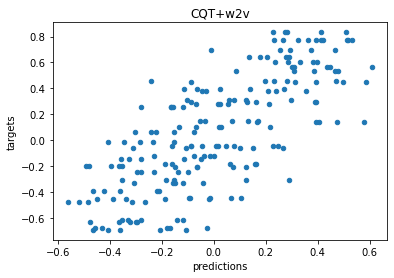

In [3]:
import pandas




dataframe = {"all_predictions":predictions,
        "all_targets":targets,
        }
df = pandas.DataFrame(dataframe)
# colors = {'best singings':'tab:red', 'worst singings':'tab:green'}
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(df['Feature_1'], df['Feature_2'], c=df['label'].map(colors))
# plt.show()

df.plot(title =["CQT+w2v"],subplots=True, x="all_predictions", y="all_targets",xlabel='predictions', ylabel='targets',kind='scatter', colormap='viridis')
